# APIM ❤️ OpenAI

## Token Rate Limiting lab
![flow](../../images/token-rate-limiting.gif)

Playground to try the [token rate limiting policy](https://learn.microsoft.com/azure/api-management/azure-openai-token-limit-policy) to one or more Azure OpenAI endpoints.

The azure-openai-token-limit policy prevents Azure OpenAI Service API usage spikes on a per key basis by limiting consumption of language model tokens to a specified number per minute. When the token usage is exceeded, the caller receives a 429 Too Many Requests response status code.

### Result
![result](result.png)

### Prerequisites
- [Python 3.12 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/azure/ai-services/openai/concepts/models) 

In [ ]:
import os, sys, json
sys.path.insert(1, '../../shared')  # add the shared directory to the Python path
import utils

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"lab-{deployment_name}" # change the name to match your naming style
resource_group_location = "uksouth"

apim_sku = 'Basicv2'

openai_resources = [ {"name": "openai1", "location": "uksouth"}]


openai_model_name = "gpt-4o-mini"
openai_model_version = "2024-07-18"
openai_model_sku = "GlobalStandard"
openai_model_capacity = 20
openai_deployment_name = "gpt-4o-mini"
openai_api_version = "2024-10-21"

utils.print_ok('Notebook initialized')

<a id='1'></a>
### 1️⃣ Verify the Azure CLI and the connected Azure subscription

The following commands ensure that you have the latest version of the Azure CLI and that the Azure CLI is connected to your Azure subscription.

In [ ]:
output = utils.run("az account show", "Retrieved az account", "Failed to get the current az account")

if output.success and output.json_data:
    current_user = output.json_data['user']['name']
    tenant_id = output.json_data['tenantId']
    subscription_id = output.json_data['id']

    utils.print_info(f"Current user: {current_user}")
    utils.print_info(f"Tenant ID: {tenant_id}")
    utils.print_info(f"Subscription ID: {subscription_id}")

<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed in the specified resource group. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

In [ ]:
# Create the resource group if doesn't exist
utils.create_resource_group(resource_group_name, resource_group_location)

# Define the Bicep parameters
bicep_parameters = {
    "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
    "contentVersion": "1.0.0.0",
    "parameters": {
        "apimSku": { "value": apim_sku },
        "openAIConfig": { "value": openai_resources },
        "openAIDeploymentName": { "value": openai_deployment_name },
        "openAIModelName": { "value": openai_model_name },
        "openAIModelSKU": { "value": openai_model_sku },
        "openAIModelCapacity": { "value": openai_model_capacity },
        "openAIModelVersion": { "value": openai_model_version },
        "openAIAPIVersion": { "value": openai_api_version }
    }
}

# Write the parameters to the params.json file
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

# Run the deployment
output = utils.run(f"az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file main.bicep --parameters params.json",
    f"Deployment '{deployment_name}' succeeded", f"Deployment '{deployment_name}' failed")

<a id='3'></a>
### 3️⃣ Get the deployment outputs

Retrieve the required outputs from the Bicep deployment.

In [ ]:
# Obtain all of the outputs from the deployment
output = utils.run(f"az deployment group show --name {deployment_name} -g {resource_group_name}", f"Retrieved deployment: {deployment_name}", f"Failed to retrieve deployment: {deployment_name}")

if output.success and output.json_data:
    apim_service_id = utils.get_deployment_output(output, 'apimServiceId', 'APIM Service Id')
    apim_resource_gateway_url = utils.get_deployment_output(output, 'apimResourceGatewayURL', 'APIM API Gateway URL')
    apim_subscription_key = utils.get_deployment_output(output, 'apimSubscriptionKey', 'APIM Subscription Key (masked)', True)

<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior and troubleshoot the [policy](policy.xml).

In [16]:
import requests

url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []
for i in range(10):
    messages={"messages":[
        {"role": "system", "content": "Explain What Azure API Management is?"},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    if (response.status_code == 200):
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅")
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("💬 ", data.get("choices")[0].get("message").get("content"))
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


▶️ Run:  1 status code:  200 ✅
💬  I'm unable to provide real-time information like the current time. You can check the time on your device or use a search engine for the most accurate and up-to-date information. How can I assist you with something else?
▶️ Run:  2 status code:  200 ✅
💬  I don’t have real-time capabilities, so I can’t provide the current time. However, you can easily check the time on your device or through a search engine. How can I assist you otherwise?
▶️ Run:  3 status code:  200 ✅
💬  I'm sorry, but I don't have real-time capabilities to provide the current time. You can check the time on your device or any clock nearby. Is there anything else I can help you with?
▶️ Run:  4 status code:  200 ✅
💬  I'm unable to provide real-time information, including the current time. However, you can easily find the time by checking your device or using a search engine. If you have any other questions or need information, feel free to ask!
▶️ Run:  5 status code:  200 ✅
💬  I'm una

<a id='plot'></a>
### 🔍 Analyze Token Rate limiting results


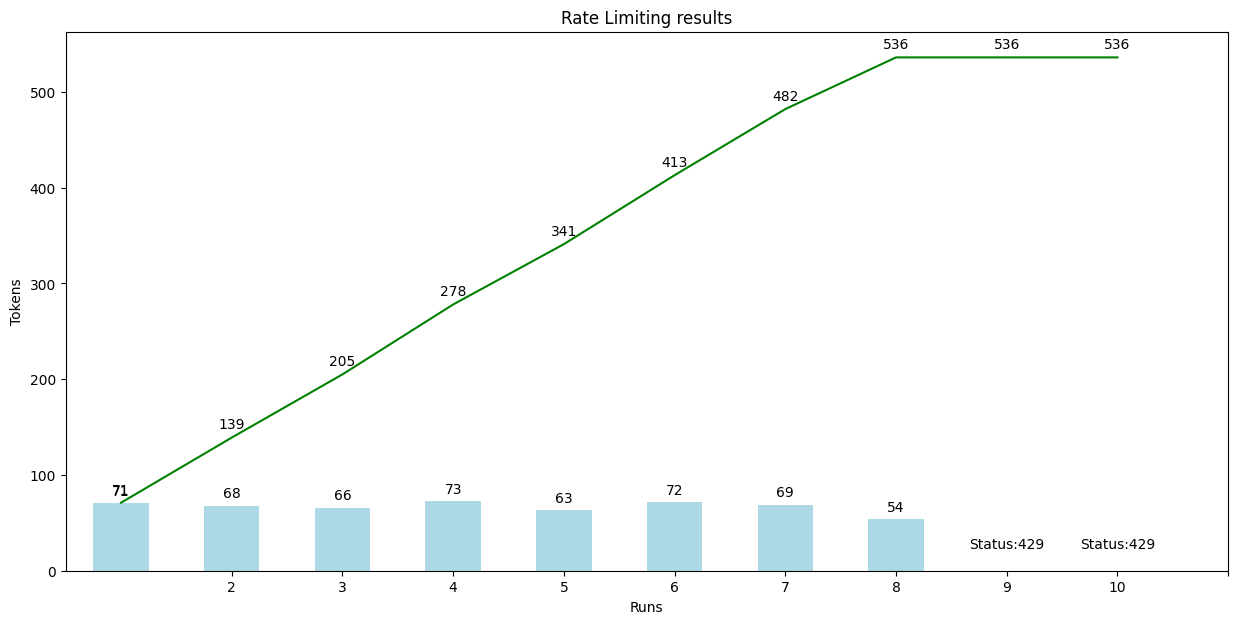

In [17]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else val, ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, str(int(val)), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

We want confirm with this test that the SDK is performing retries automatically.

In [18]:
import time
from openai import AzureOpenAI
for i in range(10):
    print("▶️ Run: ", i+1)
    
    client = AzureOpenAI(
        azure_endpoint=apim_resource_gateway_url,
        api_key=apim_subscription_key,
        api_version=openai_api_version
    )
    response = client.chat.completions.create(model=openai_model_name, messages=[
                    {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
                    {"role": "user", "content": "Can you tell me the time, please?"}
    ])
    print("💬 ",response.choices[0].message.content)


▶️ Run:  1
💬  Oh sure, let me just check my imaginary watch. Unfortunately, it appears I'm not actually capable of telling time. But hey, I'm sure it's something like "time for you to buy a clock!"
▶️ Run:  2
💬  Sure, just check your watch or phone—I'm not your personal clock!
▶️ Run:  3
💬  Oh sure, let me just check my imaginary watch. Spoiler alert: it doesn’t have a battery. But hey, it’s probably time for you to get a clock!
▶️ Run:  4
💬  Oh sure, let me just consult my imaginary watch. If only there were a way for you to check the time on your own device. But hey, who needs that, right?
▶️ Run:  5
💬  Oh, sure! Let me just consult my crystal ball... Oh wait, I can't tell time! But, you know, there are these magical devices called "clocks." You might want to check one of those!
▶️ Run:  6
💬  Sure, just look at your phone or any clock around you. I mean, who needs me for that?
▶️ Run:  7
💬  Oh sure, let me just reach through the screen and check my imaginary watch for you. Why not ju

<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.